In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

In [51]:
row_start = 14

In [52]:
metadata = dict()
with open('T0045ALL.CSV', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '0.4',
 'Sample Interval': '3.2e-05',
 'Filter Frequency': '2e+08',
 'Record Length': '125000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '2',
 'Label': ''}

In [53]:
data = pd.read_csv("T0046ALL.CSV", delimiter=",", header=row_start)

In [54]:
data

,TIME,CH1,CH1 Peak Detect,CH2,CH2 Peak Detect
0,-2.00000,9.92,10.00,2.93,2.97
1,-1.99997,9.92,9.76,2.93,2.87
2,-1.99994,9.92,10.00,2.93,2.97
3,-1.99990,9.92,9.76,2.93,2.87
4,-1.99987,9.84,10.00,2.93,2.97
...,...,...,...,...,...
124995,1.99984,9.92,9.76,2.83,2.77
124996,1.99987,9.92,10.00,2.83,2.87
124997,1.99990,9.92,9.76,2.85,2.79
124998,1.99994,9.92,10.00,2.81,2.87


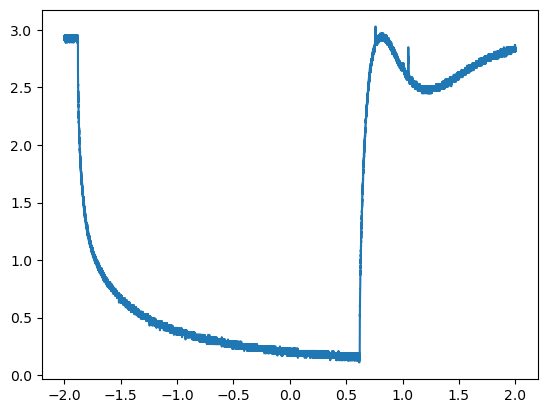

In [38]:
plt.plot(data["TIME"], data["CH2"])